# Index
1. Reading the data
2. Exploratory Data Analysis
    1. Target Variable Distrubution (check if its inbalanced)
    2. Distribution of features
    3. Missing values of features
    4. Correlation of features
    5. Description of the data (df.describe())
    6. Outlier detection (remove nonsensical data / boxplots) / (create a function to remove outliers)
    7. Check distinct values in features / check ordinal values
3. Feature Engineering
    1. Missing value imputation (mode, median, mean, k-NN, SMOTE etc.)
    2. Create new features using arithmetical transformations of existing features.
    3. PCA 
    4. Try few models to decide feature importances to reduce features. (target shuffling)
    5. Add new features using outside data sources.
    6. Train, Test, Validation split (use validation for hyperparameter tuning)
4. Modeling (find important features using models, then return to feature engineering)
    1. Linear Regression (remove multicolonarity, then check coefficient of features to determine their importance) (correlation matrix 85%>)
    2. Decision Tree
    3. Adaboost
    4. Random Forest (entropy)
    5. XGBoost
    6. LightGBM
    7. Gradient Boosting
    8. Ensemble Learning
5. Hyperparameter Tuning
    1. Optuna

# Dependencies & Functions

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from sklearn import linear_model as lin 
from sklearn import preprocessing as pre
from sklearn import metrics as met
from sklearn import model_selection as mod
from sklearn import pipeline as pip
from sklearn import datasets as dat
from sklearn import tree
from sklearn import preprocessing as pre
from sklearn import ensemble as ens
from sklearn import svm
from sklearn import decomposition as dec
from sklearn import manifold as man
from sklearn import impute as imp
from sklearn import compose as com

from imblearn import pipeline as imbPip # imblearn pipeline
from imblearn import under_sampling as und
from imblearn import over_sampling as ove

import xgboost as xgb

import seaborn as sns

from pandas_profiling import ProfileReport as p_rep

import lightgbm as lgbm

import datetime as dtime

from scipy import stats

import math

from typing import List

np.set_printoptions(suppress=True) 

import warnings
warnings.filterwarnings("ignore")

# Reading the Data

In [2]:
# Variables
Data_Path = "Data/train.xlsx"
Target = "is claim"

In [3]:
#df = pd.read_csv('Data_Path')
df = pd.read_excel(Data_Path)
df.set_index("ID",inplace=True)

# Explorary Data Analysis

In [4]:
'''df_profile = p_rep(df, title="Profiling Report")
now = dtime.datetime.now()
timestamp = now.strftime('%Y%m%d%H%M')
filename = f'data_report_{timestamp}.html'
df_profile.to_file(filename)
'''


'df_profile = p_rep(df, title="Profiling Report")\nnow = dtime.datetime.now()\ntimestamp = now.strftime(\'%Y%m%d%H%M\')\nfilename = f\'data_report_{timestamp}.html\'\ndf_profile.to_file(filename)\n'

## Target Value Distribution

In [5]:
def print_data_distribution(df, col):
  value_counts = df[col].value_counts()
  
  n = df.shape[0]
  
  results = []
  
  for value, count in value_counts.items():
    pct = 100 * count / n
    
    results.append([value, count, pct])
  
  df_results = pd.DataFrame(results, columns=[col, 'Count', 'Percentage'])
  
  print(df_results)

In [6]:
print_data_distribution(df, Target)

   is claim  Count  Percentage
0         0  40804   93.604331
1         1   2788    6.395669


## Distribution of Features

In [7]:
def explore_features(df):
  columns = df.columns
  
  results = []
  
  for col in columns:
    dtype = df[col].dtype
    
    unique_values = df[col].nunique()
    
    if df[col].dtype in ['int64', 'float64']:
      skewness = df[col].skew()
    else:
      skewness = 'N/A'
    
    missing_values = df[col].isnull().sum()
    
    pct_missing = 100 * missing_values / df.shape[0]
    
    results.append([col, dtype, unique_values, skewness, missing_values, pct_missing])
  
  df_results = pd.DataFrame(results, columns=['Column', 'Data Type', 'Unique Values',
                                             'Skewness', 'Missing Values', '% Missing'])
  
  df_results = df_results.sort_values('Data Type')
    
  return df_results



In [8]:
explore_features(df)

,Column,Data Type,Unique Values,Skewness,Missing Values,% Missing
43,is claim,int64,2,3.564377,0,0.000000
42,area danger level,int64,5,0.008684,0,0.000000
41,turning radius,float64,9,0.412252,98,0.224812
40,airbags,float64,3,0.89474,86,0.197284
39,gear box,float64,2,1.174558,116,0.266104
36,gross weight,float64,10,0.538934,97,0.222518
33,width,float64,10,-0.498649,74,0.169756
32,length,float64,9,0.139318,88,0.201872
28,time period,float64,43510,0.055738,82,0.188108
26,population,float64,1949,1.673871,95,0.217930


## Missing Values

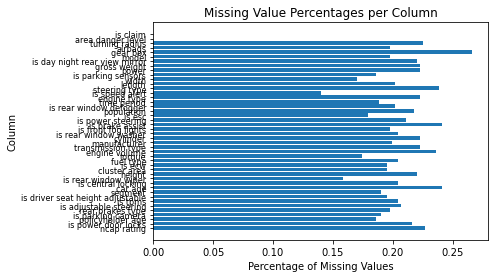

<Figure size 1152x864 with 0 Axes>

In [9]:

missing_values = df.isnull().sum()

missing_pct = 100 * missing_values / df.shape[0]

plt.barh(missing_pct.index, missing_pct.values)

plt.xlabel('Percentage of Missing Values')
plt.ylabel('Column')
plt.title('Missing Value Percentages per Column')
plt.yticks(fontsize=8)
plt.figure(figsize=(16, 12))
plt.show()

## Correlation of Features

In [10]:
df_X = df.drop(columns=Target)

numerical_cols = df_X.select_dtypes(include=['float64', 'int64']).columns
if numerical_cols.size > 0:
    print("Numerical columns:", numerical_cols)
else:
    print("No numerical columns found.")

categorical_cols = df_X.select_dtypes(include=['object']).columns
if categorical_cols.size > 0:
    print("Categorical columns:", categorical_cols)
else:
    print("No categorical columns found.")
    
datetime_cols = df_X.select_dtypes(include=['datetime']).columns
if datetime_cols.size > 0:
    print("Datetime columns:", datetime_cols)
else:
    print("No datetime columns found.")
    
boolean_cols = df_X.select_dtypes(include=['bool']).columns
if boolean_cols.size > 0:
    print("Boolean columns:", boolean_cols)
else:
    print("No boolean columns found.")

Numerical columns: Index(['ncap rating', 'policyholder age', 'car age', 'height', 'engine volume',
       'manufacturer', 'cylinder', 'population', 'time period', 'length',
       'width', 'gross weight', 'gear box', 'airbags', 'turning radius',
       'area danger level'],
      dtype='object')
Categorical columns: Index(['is power door locks', 'is parking camera', 'rear brakes type',
       'is adjustable steering', 'is tpms', 'is driver seat height adjustable',
       'segment', 'is central locking', 'is rear window wiper', 'cluster area',
       'is ecw', 'fuel type', 'torque', 'transmission type',
       'is rear window washer', 'is front fog lights', 'is brake assist',
       'is power steering', 'is esc', 'is rear window defogger', 'engine type',
       'is speed alert', 'steering type', 'is parking sensors', 'power',
       'is day night rear view mirror', 'model'],
      dtype='object')
No datetime columns found.
No boolean columns found.


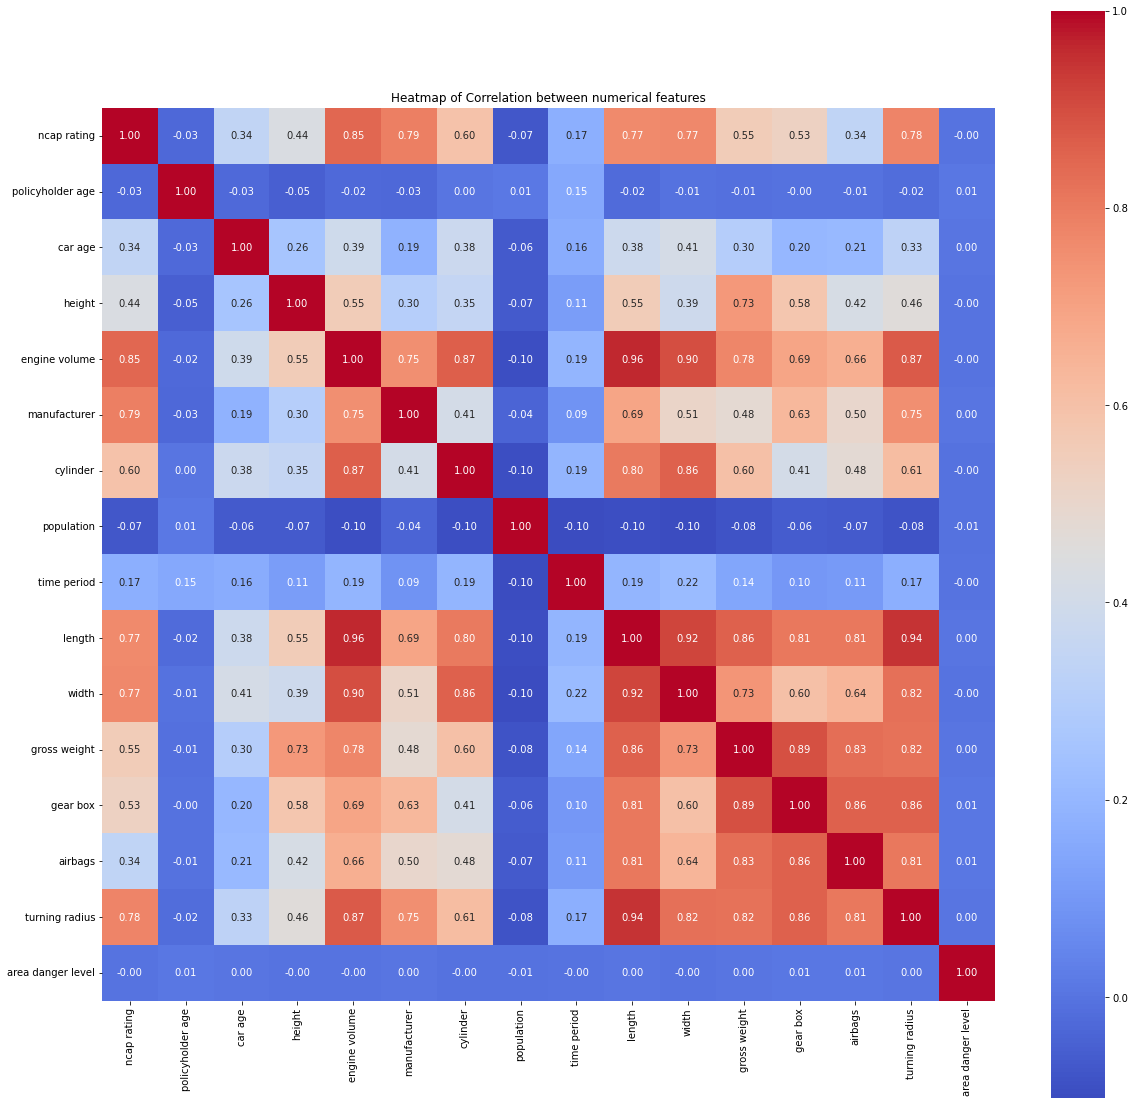

In [11]:

corr = df[numerical_cols].corr()

fig, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(corr, annot=True,fmt='.2f', cmap='coolwarm', square=True, ax=ax)

plt.title("Heatmap of Correlation between numerical features")
plt.show()

In [12]:
def correlated_features_heatmap(df, num_top_features):
    numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
    corr = df[numerical_cols].corr()
    corr_abs = corr.abs()

    mask = np.triu(np.ones_like(corr, dtype=bool)) 
    
    most_correlated = corr_abs.where(mask).stack().sort_values(ascending=False)
    top_n_correlated = most_correlated[most_correlated > 0.8].drop_duplicates().head(num_top_features)
    fig, ax = plt.subplots(figsize=(8,8))
    sns.heatmap(df[top_n_correlated.index.get_level_values(0)].corr(), annot=True, fmt='.2f', cmap='coolwarm', square=True,ax=ax)
    plt.title(f"Heatmap of Most Correlated Features (Top {num_top_features})")
    plt.show()


    least_correlated = corr_abs.where(mask).stack().sort_values(ascending=True)
    top_n_least_correlated = least_correlated[least_correlated < 0.1].drop_duplicates().head(num_top_features)
    fig, ax = plt.subplots(figsize=(8,8))
    sns.heatmap(df[top_n_least_correlated.index.get_level_values(0)].corr(), annot=True, fmt='.2f', cmap='coolwarm', square=True,ax=ax)

    plt.title(f"Heatmap of Least Correlated Features (Top {num_top_features})")
    plt.show()


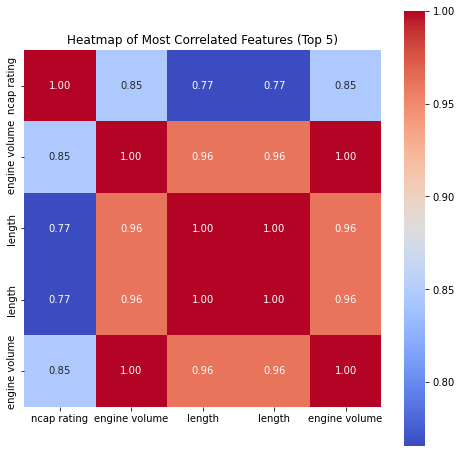

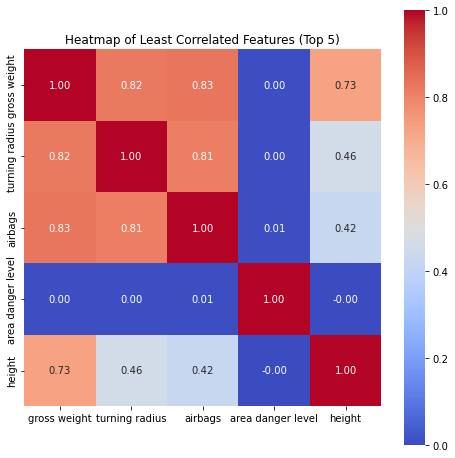

In [13]:
correlated_features_heatmap(df,5)

## Outlier Detection

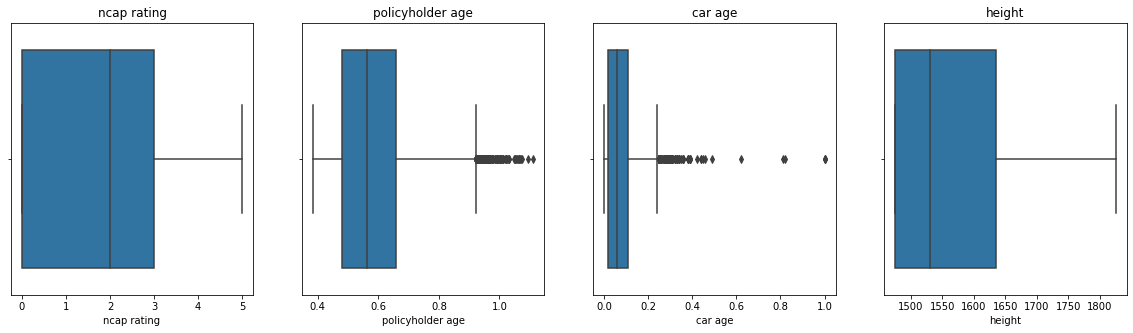

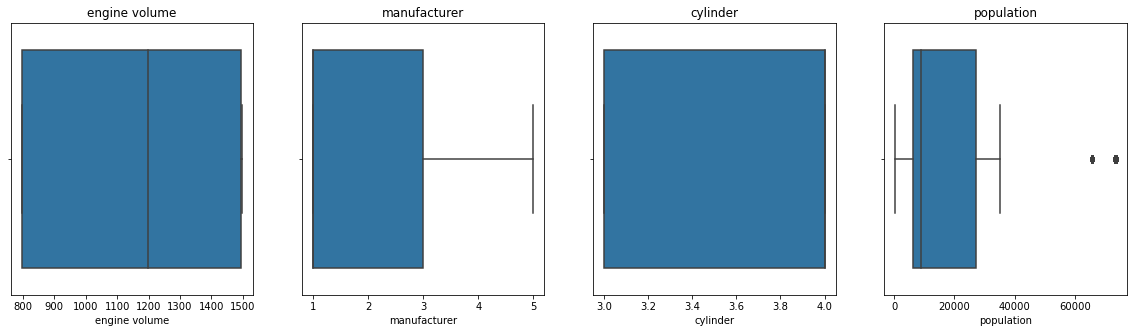

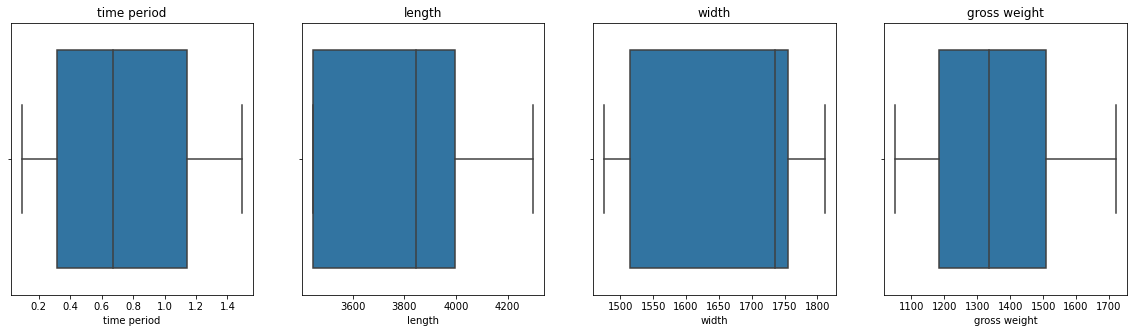

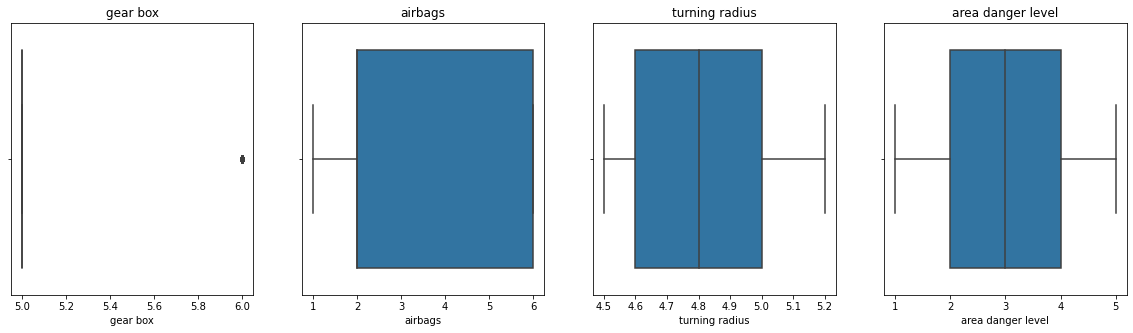

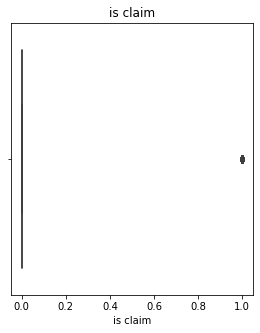

In [14]:
def print_boxplots(df):
    numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
    num_plots = math.ceil(len(numerical_cols) / 4)
    for i in range(num_plots):
        plt.figure(figsize=(20,5))
        for j in range(4):
            if i*4+j < len(numerical_cols):
                plt.subplot(1, 4, j+1)
                sns.boxplot(data=df, x=numerical_cols[i*4+j])
                plt.title(numerical_cols[i*4+j])
        plt.show()
print_boxplots(df)

In [15]:
def drop_outliers_zscore(df):
    numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
    outliers_removed = df.copy()
    rows_removed = 0
    for col in numerical_cols:
        z_scores = np.abs(stats.zscore(df[col]))
        outliers = np.where(z_scores > 3)
        rows_removed += len(outliers[0])
        outliers_removed = outliers_removed.drop(outliers_removed.index[outliers])
    print(f'{rows_removed} rows removed, which is {(rows_removed/len(df)*100):.2f}% of the total')
    return outliers_removed

drop_outliers_zscore(df).head(5)

2788 rows removed, which is 6.40% of the total


,ncap rating,is power door locks,policyholder age,is parking camera,rear brakes type,is adjustable steering,is tpms,is driver seat height adjustable,segment,car age,...,is parking sensors,power,gross weight,is day night rear view mirror,model,gear box,airbags,turning radius,area danger level,is claim
ID,,,,,,,,,,,,,,,,,,,,,
0,2.0,Yes,0.394496,No,Drum,No,No,No,B1,0.08,...,Yes,55.92bhp@5300rpm,1340.0,No,Model_8,5.0,2.0,4.7,4,0
2,2.0,Yes,0.438922,No,Drum,Yes,No,Yes,B2,0.03,...,Yes,88.50bhp@6000rpm,1335.0,Yes,Model_6,5.0,2.0,4.8,5,0
3,0.0,No,0.656276,No,Drum,No,No,No,A,0.04,...,Yes,40.36bhp@6000rpm,1185.0,No,Model_1,5.0,2.0,4.6,2,0
4,3.0,Yes,0.462328,Yes,Disc,Yes,Yes,Yes,C2,0.04,...,Yes,113.45bhp@4000rpm,1720.0,No,Model_4,6.0,6.0,5.2,3,0
5,0.0,No,0.593278,No,Drum,No,No,No,A,0.03,...,Yes,40.36bhp@6000rpm,1185.0,No,Model_1,5.0,2.0,4.6,5,0


# Feature Engineering

## Missing Value Imputation
Mode, Median, Mean, k-NN, SMOTE 

In [16]:
pipe_num = pip.Pipeline([
    ("imp", imp.SimpleImputer(strategy='median')),
    #("imp", imp.IterativeImputer(random_state=0, sample_posterior=True, max_iter=10)),
    #("imp", imp.KNNImputer(n_neighbors=5)),
    #("scale", pre.StandardScaler())
])

pipe_cat = pip.Pipeline([
    ("imp", imp.SimpleImputer(strategy="most_frequent")),
    #("imp", imp.IterativeImputer(random_state=0, sample_posterior=True, max_iter=10)),
    #("imp", imp.KNNImputer(n_neighbors=5)),
    ("encoding", pre.OneHotEncoder(handle_unknown="ignore", sparse=True)) 
])



## Create New Features
Use arithmetical transformation of existing features

In [17]:
pipe_num_New_Features = pip.Pipeline([
    ("imp", imp.SimpleImputer(strategy='median')),
    #("imp", imp.IterativeImputer(random_state=0, sample_posterior=True, max_iter=10)),
    #("imp", imp.KNNImputer(n_neighbors=5)),
    #("scale", pre.StandardScaler())
    ("poly", pre.PolynomialFeatures(degree=2)),
    #("inter", pre.PolynomialFeatures(degree=2, interaction_only=True)),
    #("bin", pre.KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile'))

])

## PCA

In [18]:
pipe_num_PCA = pip.Pipeline([
    ("imp", imp.SimpleImputer(strategy='median')),
    #("imp", imp.IterativeImputer(random_state=0, sample_posterior=True, max_iter=10)),
    #("imp", imp.KNNImputer(n_neighbors=5)),
    #("scale", pre.StandardScaler())
    ("poly", pre.PolynomialFeatures(degree=2)),
    #("inter", pre.PolynomialFeatures(degree=2, interaction_only=True)),
    #("bin", pre.KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile'))
    ('pca', dec.PCA(n_components=0.95)),
])

## Column Transformer

In [19]:
ct = com.ColumnTransformer([
    ("num", pipe_num, numerical_cols),
    ("cat", pipe_cat, categorical_cols)
])

## Train Test Validation Split

In [20]:
X = df.drop(columns=Target)
y = df[Target]



X_train, X_test, y_train, y_test = mod.train_test_split(X, y, test_size=0.2, random_state=42)

X_test, X_val, y_test, y_val = mod.train_test_split(X_test, y_test, test_size=0.5, random_state=42)

## Feature Importance

In [21]:

def feature_importances(X_train, y_train, models):
    num_cols = X_train.select_dtypes(exclude=['object']).columns
    cat_cols = X_train.select_dtypes(include=['object']).columns
    num_transformer = imp.SimpleImputer()
    cat_transformer = pip.Pipeline(steps=[
        ('imputer', imp.SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', pre.OneHotEncoder(handle_unknown='ignore'))])

    preprocessor = com.ColumnTransformer(
        transformers=[
            ('num', num_transformer, num_cols),
            ('cat', cat_transformer, cat_cols)])
    cat_transformer.fit(X_train[cat_cols])
    X_train_preprocessed = preprocessor.fit_transform(X_train)
    features = num_cols.tolist() + list(cat_transformer.named_steps['onehot'].get_feature_names(input_features=cat_cols))
    feature_dict = {}
    for model in models:
        model.fit(X_train_preprocessed, y_train)
        importances = model.feature_importances_
        feature_importances = dict(zip(features, importances))
        for feature, importance in feature_importances.items():
            if feature not in feature_dict:
                feature_dict[feature] = [importance]
            else:
                feature_dict[feature].append(importance)
    sorted_feature = {k: v for k, v in sorted(feature_dict.items(), key=lambda item: np.mean(item[1]), reverse=False)}
    feature_importances = [np.mean(val) for val in sorted_feature.values()]
    feature_names = list(sorted_feature.keys())
    feature_importances = feature_importances[:15]
    feature_names = feature_names[:15]
    plt.figure(figsize=(10,5))
    plt.barh(feature_names, feature_importances)
    plt.xlabel('Feature importances')
    plt.ylabel('Feature names')
    plt.show()
    return sorted_feature

In [22]:
models = [ens.RandomForestRegressor(random_state=42), 
#          ens.RandomForestRegressor(random_state=34), 
#          ens.RandomForestRegressor(random_state=22)
]

# fi_Dict = feature_importances(X_train, y_train, models)

In [35]:
#not working need to check
def drop_less_important_cat_cols(df, model, threshold): 
    num_cols = df.select_dtypes(exclude=['object']).columns
    cat_cols = df.select_dtypes(include=['object']).columns
    
    X = df[num_cols]
    y = df[Target]
    X_cat = df[cat_cols]
    X_cat_encoded = pd.get_dummies(X_cat, columns=cat_cols)
    X_encoded = pd.concat([X, X_cat_encoded], axis=1)
    
    model.fit(X_encoded, y)
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    feature_names = X_encoded.columns
    
    to_keep = []
    for i in range(X_encoded.shape[1]):
        if importances[indices[i]] > threshold:
            to_keep.append(feature_names[indices[i]])
    
    to_keep = list(set(to_keep).intersection(X_cat_encoded.columns))
    X_encoded = X_encoded[to_keep]
    
    return X_encoded

In [60]:
def drop_less_important_cols(X, y, threshold=0.01, model=ens.RandomForestClassifier(random_state=42)):
    model.fit(X, y)
    feature_importances = model.feature_importances_
    feature_importances_df = pd.DataFrame({"feature": X.columns, "importance": feature_importances})
    feature_importances_df["importance_type"] = "kept"
    feature_importances_df.loc[feature_importances_df["importance"] < threshold, "importance_type"] = "dropped"
    X_dropped = X.loc[:, feature_importances_df.loc[feature_importances_df["importance_type"] == "kept", "feature"]]
    dropped_cols = feature_importances_df.loc[feature_importances_df["importance_type"] == "dropped", "feature"]
    print(f"{len(dropped_cols)} columns were dropped: {dropped_cols.tolist()}")
    return X_dropped, feature_importances_df


# Modeling

## Linear Regression
(remove multicolonarity, then check coefficient of features to determine their importance) (correlation matrix 85%>)

In [29]:
def eliminate_multicollinearity(df, threshold):
    # Create correlation matrix
    corr_matrix = df.corr().abs()
    
    # Select upper triangle of correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
    
    # Find index of feature columns with correlation greater than threshold
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    
    # Calculate percentage of data lost
    data_loss = len(to_drop)/df.shape[1] * 100
    print(f"{len(to_drop)} columns removed, which is {data_loss:.2f}% of the total")
    
    # Drop correlated features
    df = df.drop(df[to_drop], axis=1)
    
    return df

In [57]:
df_linreg = drop_outliers_zscore(df)
df_linreg = eliminate_multicollinearity(df_linreg, 0.85)

X = df_linreg.drop(columns=Target)
y = df_linreg[Target]


num_cols_linreg = X.select_dtypes(include=['float', 'int']).columns
cat_cols_linreg = X.select_dtypes(include=['object']).columns

num_cols_linreg.shape, cat_cols_linreg.shape

2788 rows removed, which is 6.40% of the total
7 columns removed, which is 15.91% of the total


((9,), (27,))

In [58]:
pipe_num_linreg = pip.Pipeline([
    ("imp", imp.SimpleImputer(strategy='median')),
    #("imp", imp.IterativeImputer(random_state=0, sample_posterior=True, max_iter=10)),
    #("imp", imp.KNNImputer(n_neighbors=5)),
    ("scale", pre.StandardScaler()),
    ('pca', dec.PCA(n_components=0.9))
])

pipe_cat_linreg = pip.Pipeline([
    ("imp", imp.SimpleImputer(strategy="most_frequent")),
    #("imp", imp.IterativeImputer(random_state=0, sample_posterior=True, max_iter=10)),
    #("imp", imp.KNNImputer(n_neighbors=5)),
    ("encoding", pre.OneHotEncoder(handle_unknown="ignore", sparse=True)) 
])

ct_linreg = com.ColumnTransformer([
    ("num", pipe_num_linreg, num_cols_linreg),
    ("cat", pipe_cat_linreg, cat_cols_linreg)
])


In [61]:
X_processed = ct_linreg.fit_transform(X)

drop_less_important_cols(X_processed, y)

AttributeError: columns not found

## Decision Tree

## Adaboost

## Random Forest
check for entropy

## XGBoost

## LightGBM

## Gradient Boosting

## Ensemble Learning

# Hyperparameter Tuning

## Grid Search